In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
column_names = ["date", "time", "epoch", "moteid", "temperature", "humidity", "light", "voltage"]

In [3]:
df = pd.read_csv('data.txt',
                   sep='\s+',
                   header=None,
                   names=column_names,
                   engine='python')


In [4]:
df['timestamp'] = pd.to_datetime(df['date'] + " " + df['time'], errors='coerce')
df.drop(columns=['date', 'time'], inplace=True)
df.sort_values(by=['timestamp'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [5]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [6]:
mote_id = 1
df = df.loc[df['moteid'] == mote_id].copy()
df.reset_index(inplace=True, drop=True)

In [7]:
sensor_cols = ['temperature', 'humidity', 'light', 'voltage']

In [8]:
scaler = MinMaxScaler()
df[sensor_cols] = scaler.fit_transform(df[sensor_cols])

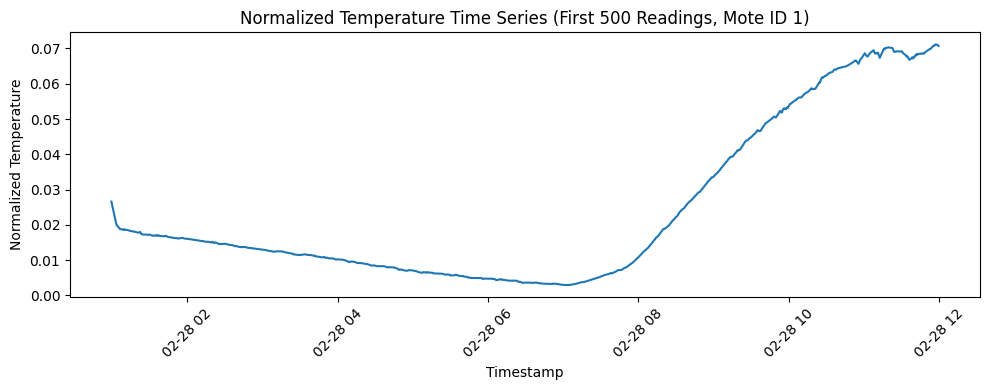

In [9]:
plt.figure(figsize=(10, 4))
plt.plot(df['timestamp'].iloc[:500], df['temperature'].iloc[:500])
plt.title("Normalized Temperature Time Series (First 500 Readings, Mote ID 1)")
plt.xlabel("Timestamp")
plt.ylabel("Normalized Temperature")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [10]:
subset_data = df.iloc[:5000]

In [11]:
window_size = 60

def create_windows(df, window_size, cols):
    windows = []
    for i in range(len(df) - window_size):
        window = df[cols].iloc[i:i+window_size][cols].values
        windows.append(window)
    return np.array(windows)

windows = create_windows(subset_data, window_size, sensor_cols)
print("Total windows shape:", windows.shape)

Total windows shape: (4940, 60, 4)


In [12]:
train_auto, test_auto = train_test_split(windows, test_size=0.2, random_state=42)

In [13]:
from tensorflow.keras.regularizers import l2

timesteps, n_features = window_size, len(sensor_cols)

input_layer = Input(shape=(timesteps, n_features))
encoded = LSTM(16, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01), dropout=0.3)(input_layer)
decoded_repeat = RepeatVector(timesteps)(encoded)
decoded = LSTM(16, activation='relu', return_sequences=True, dropout=0.3)(decoded_repeat)
decoded = TimeDistributed(Dense(n_features))(decoded)

autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 60, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 16)             │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 60, 16)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 60, 16)         │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 60, 4)          │            68 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,524 (13.77 KB)

 Trainable params: 3,524 (13.77 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
print("Autoencoder parameters:", autoencoder.count_params())

Autoencoder parameters: 3524


In [15]:
from tensorflow.keras.callbacks import Callback
import time

class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.times = []
    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()
    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [16]:
time_callback_auto = TimeHistory()
start_time_auto = time.time()
history = autoencoder.fit(train_auto, train_auto, epochs=50, batch_size=32,
                          validation_data=(test_auto, test_auto),
                          callbacks=[time_callback_auto])
end_time_auto = time.time()
total_time_auto = end_time_auto - start_time_auto
print("Total autoencoder training time (s):", total_time_auto)
print("Average time per epoch (s):", np.mean(time_callback_auto.times))

Epoch 1/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - loss: 0.2394 - val_loss: 0.0610
Epoch 2/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0468 - val_loss: 0.0289
Epoch 3/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 4s 30ms/step - loss: 0.0260 - val_loss: 0.0172
Epoch 4/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0183 - val_loss: 0.0131
Epoch 5/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0134 - val_loss: 0.0092
Epoch 6/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0106 - val_loss: 0.0087
Epoch 7/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0091 - val_loss: 0.0066
Epoch 8/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0080 - val_loss: 0.0057
Epoch 9/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 10/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0067 - val_loss: 0.0062
Epoch 11/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0064 - val_loss: 0.0038
Epoch 12/50
124/124 ━━━━━━━━━━━━━━━━━━━━ 

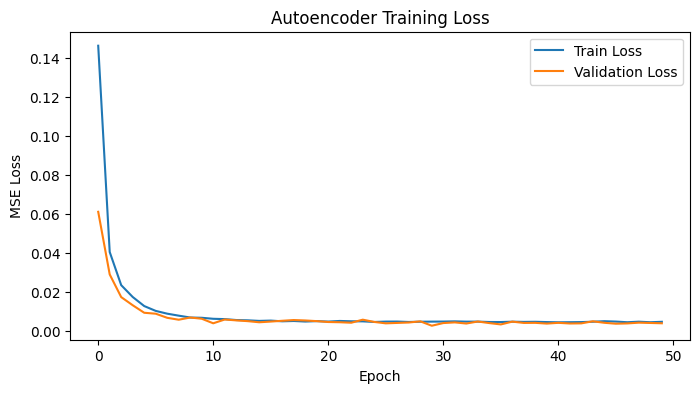

In [17]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

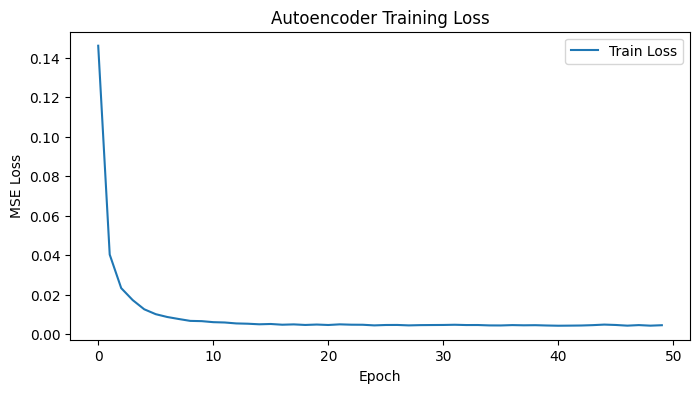

In [18]:
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Train Loss')
plt.title("Autoencoder Training Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()

In [20]:
reconstructions = autoencoder.predict(windows)
mse = np.mean(np.power(reconstructions - windows, 2), axis=(1, 2))
threshold = np.percentile(mse, 98)
print("Anomaly threshold:", threshold)

155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Anomaly threshold: 0.02041961065714411


In [21]:
anomaly_flags = mse > threshold

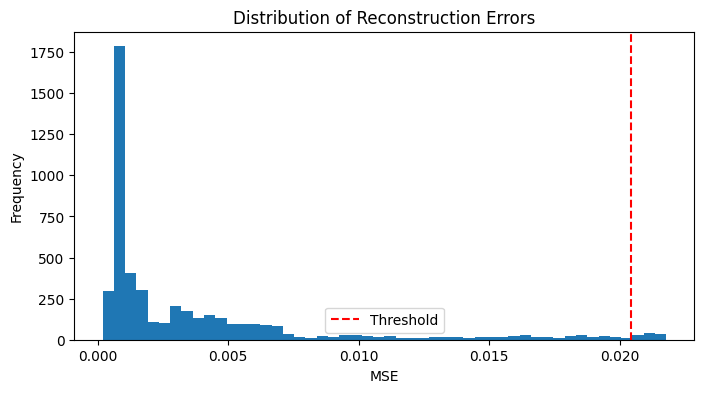

In [22]:
plt.figure(figsize=(8, 4))
plt.hist(mse, bins=50)
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')
plt.title("Distribution of Reconstruction Errors")
plt.xlabel("MSE")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [23]:
print(f"Percentage of anomalies detected: {np.mean(anomaly_flags) * 100:.2f}%")

Percentage of anomalies detected: 2.00%


In [39]:
reconstructions = autoencoder.predict(windows)
mse = np.mean(np.power(windows - reconstructions, 2), axis=(1,2))


155/155 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


In [44]:
for p in [90, 92, 94, 95, 96, 97, 98, 99]:
    thresh = np.percentile(mse, p)
    flags = mse > thresh
    anomaly_ratio = np.mean(flags) * 100
    print(f"{p}th percentile = {thresh:.6f} => {anomaly_ratio:.2f}% anomalies")

90th percentile = 0.010597 => 10.00% anomalies
92th percentile = 0.013420 => 8.02% anomalies
94th percentile = 0.016075 => 6.01% anomalies
95th percentile = 0.016975 => 5.00% anomalies
96th percentile = 0.018287 => 4.01% anomalies
97th percentile = 0.019191 => 3.02% anomalies
98th percentile = 0.020420 => 2.00% anomalies
99th percentile = 0.021131 => 1.01% anomalies


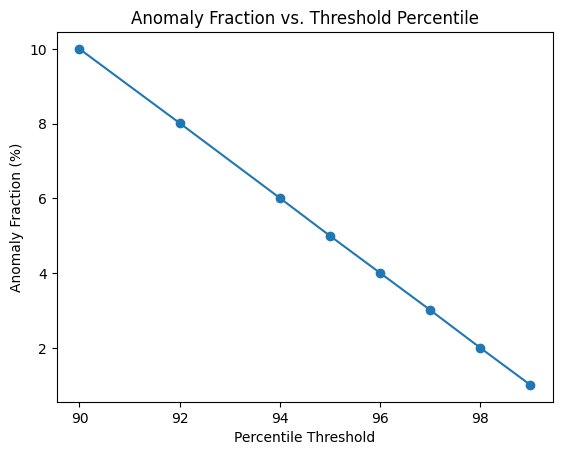

In [45]:
percentiles = [90, 92, 94, 95, 96, 97, 98, 99]
anomaly_percents = []
for p in percentiles:
    t = np.percentile(mse, p)
    anomaly_percents.append(np.mean(mse > t)*100)

plt.plot(percentiles, anomaly_percents, marker='o')
plt.title("Anomaly Fraction vs. Threshold Percentile")
plt.xlabel("Percentile Threshold")
plt.ylabel("Anomaly Fraction (%)")
plt.show()


In [46]:
for p in percentiles:
    thresh = np.percentile(mse, p)
    flags = mse > thresh
    anomaly_ratio = np.mean(flags) * 100
    print(f"{p}th percentile => threshold={thresh:.6f}, anomalies={anomaly_ratio:.2f}%")

90th percentile => threshold=0.010597, anomalies=10.00%
92th percentile => threshold=0.013420, anomalies=8.02%
94th percentile => threshold=0.016075, anomalies=6.01%
95th percentile => threshold=0.016975, anomalies=5.00%
96th percentile => threshold=0.018287, anomalies=4.01%
97th percentile => threshold=0.019191, anomalies=3.02%
98th percentile => threshold=0.020420, anomalies=2.00%
99th percentile => threshold=0.021131, anomalies=1.01%


In [24]:
prediction_horizon = 10

forecast_labels = []
for i in range(len(anomaly_flags) - prediction_horizon):
    label = 1 if np.any(anomaly_flags[i+1:i+1+prediction_horizon]) else 0
    forecast_labels.append(label)

forecast_labels = np.array(forecast_labels)

In [25]:
window_features = np.array([np.mean(w, axis=0) for w in windows[:-prediction_horizon]])

In [26]:
anomaly_feature = mse[:len(window_features)].reshape(-1, 1)
forecast_input = np.concatenate([window_features, anomaly_feature], axis=1)

In [27]:
forecast_input = forecast_input.reshape((forecast_input.shape[0], 1, forecast_input.shape[1]))
print("Forecast input shape:", forecast_input.shape)

Forecast input shape: (4930, 1, 5)


In [28]:
X_train, X_test, y_train, y_test = train_test_split(forecast_input, forecast_labels, test_size=0.2, random_state=42)

In [29]:
forecast_model = Sequential([
    LSTM(50, activation='relu', input_shape=(forecast_input.shape[1], forecast_input.shape[2])),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

c:\Users\APEX\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [30]:
forecast_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
forecast_model.summary()
print("Forecasting model parameters:", forecast_model.count_params())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

Forecasting model parameters: 11251


In [31]:
time_callback_forecast = TimeHistory()
start_time_forecast = time.time()
history_forecast = forecast_model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
                                      callbacks=[time_callback_forecast])
end_time_forecast = time.time()
total_time_forecast = end_time_forecast - start_time_forecast
print("Total forecasting model training time (s):", total_time_forecast)
print("Average time per epoch (s):", np.mean(time_callback_forecast.times))

Epoch 1/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9464 - loss: 0.6327 - val_accuracy: 0.9861 - val_loss: 0.4252
Epoch 2/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9753 - loss: 0.3580 - val_accuracy: 0.9861 - val_loss: 0.1644
Epoch 3/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9729 - loss: 0.1743 - val_accuracy: 0.9861 - val_loss: 0.0975
Epoch 4/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9733 - loss: 0.1332 - val_accuracy: 0.9861 - val_loss: 0.0815
Epoch 5/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9734 - loss: 0.1262 - val_accuracy: 0.9861 - val_loss: 0.0740
Epoch 6/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9798 - loss: 0.0962 - val_accuracy: 0.9861 - val_loss: 0.0683
Epoch 7/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9735 - loss: 0.1083 - val_accuracy: 0.9861 - val_loss: 0.0624
Epoch 8/50
99/99 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9735 - loss: 0.0997 - val_accuracy: 0.9861 - val_loss:

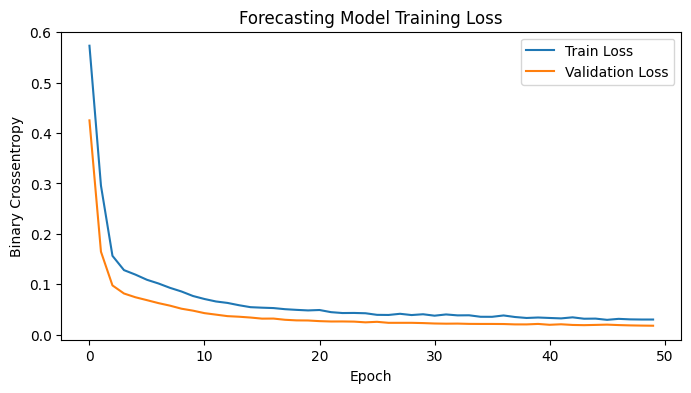

In [32]:
plt.figure(figsize=(8, 4))
plt.plot(history_forecast.history['loss'], label='Train Loss')
plt.plot(history_forecast.history['val_loss'], label='Validation Loss')
plt.title("Forecasting Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.show()

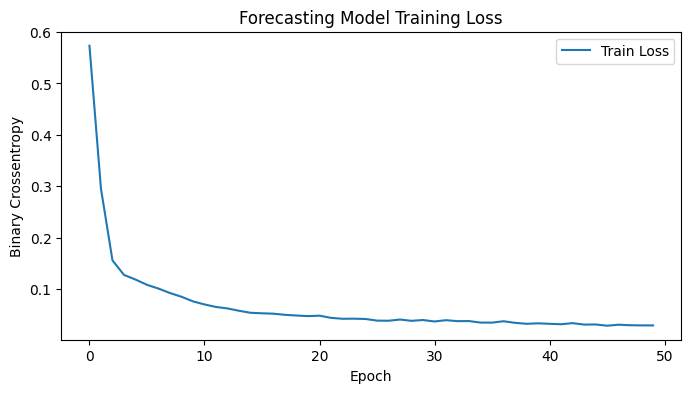

In [33]:
plt.figure(figsize=(8, 4))
plt.plot(history_forecast.history['loss'], label='Train Loss')
plt.title("Forecasting Model Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Binary Crossentropy")
plt.legend()
plt.show()

In [34]:
loss, accuracy = forecast_model.evaluate(X_test, y_test)
print("Forecasting model accuracy:", accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0226 
Forecasting model accuracy: 0.9969574213027954


In [35]:
y_pred = forecast_model.predict(X_test)
y_pred_class = (y_pred > 0.5).astype(int)
print(classification_report(y_test, y_pred_class))

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       968
           1       1.00      0.83      0.91        18

    accuracy                           1.00       986
   macro avg       1.00      0.92      0.95       986
weighted avg       1.00      1.00      1.00       986



In [36]:
loss, accuracy = forecast_model.evaluate(X_test, y_test)
print("Forecasting model accuracy:", accuracy)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9970 - loss: 0.0226 
Forecasting model accuracy: 0.9969574213027954


In [49]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

y_pred_proba = forecast_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
print("ROC-AUC Score:", roc_auc)

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
ROC-AUC Score: 0.9998852157943068


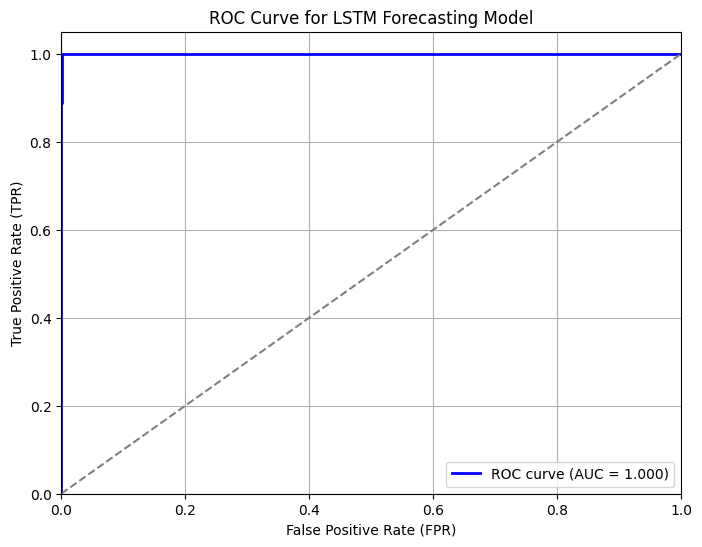

In [50]:
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate (FPR)")
plt.ylabel("True Positive Rate (TPR)")
plt.title("ROC Curve for LSTM Forecasting Model")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()